# feature extraction

In [1]:
from keras import models
from keras import layers
from keras import optimizers

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras.applications import VGG16

conv_base = VGG16(include_top=False, weights='imagenet', input_shape=(150,150,3))
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [3]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

### straight features consuming

In [4]:
base_dir = '/home/dogs-vs-cats/'

if os.path.exists(base_dir + '/train'):
    train_dir = base_dir + '/train'
if os.path.exists(base_dir + '/validation'):
    val_dir = base_dir + 'validation'
if os.path.exists(base_dir + '/test'):
    test_dir = base_dir + '/test'

batch_size = 20
datagen = ImageDataGenerator(rescale=1./255)
    
def feature_extraction(dir, samples_count):
    
    features = np.zeros((samples_count, 4,4,512))
    feature_labels = np.zeros((samples_count,))
    
    generator = datagen.flow_from_directory(dir, target_size=(150,150),class_mode='binary',batch_size=batch_size)
    
    i=0
    for inputs, labels in generator:
        pred_features = conv_base.predict(inputs)
        features[i*batch_size:(i+1)*batch_size] = pred_features
        feature_labels[i*batch_size:(i+1)*batch_size] = labels
        i+=1
        if i*batch_size >= samples_count:
            break
    
    return features, feature_labels

train_features, train_labels = feature_extraction(train_dir, 2000)
val_features, val_labels = feature_extraction(val_dir, 1000)
#test_features, test_labels = feature_extraction(test_dir, 2000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [5]:
train_features = train_features.reshape((2000, 4 * 4 * 512))
val_features = val_features.reshape((1000, 4 * 4 * 512))

In [6]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizers.rmsprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc'])

In [7]:
history = model.fit(train_features, train_labels, 
    epochs=30, 
    batch_size=batch_size, 
    validation_data=(val_features,val_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.5889 - acc: 0.6725 - val_loss: 0.4447 - val_acc: 0.8280
Epoch 2/30
2000/2000 [==============================] - 2s 833us/step - loss: 0.4276 - acc: 0.8025 - val_loss: 0.3642 - val_acc: 0.8550
Epoch 3/30
2000/2000 [==============================] - 2s 817us/step - loss: 0.3537 - acc: 0.8490 - val_loss: 0.3257 - val_acc: 0.8750
Epoch 4/30
2000/2000 [==============================] - 2s 831us/step - loss: 0.3211 - acc: 0.8700 - val_loss: 0.3062 - val_acc: 0.8830
Epoch 5/30
2000/2000 [==============================] - 2s 791us/step - loss: 0.2855 - acc: 0.8875 - val_loss: 0.2859 - val_acc: 0.8890
Epoch 6/30
2000/2000 [==============================] - 2s 799us/step - loss: 0.2551 - acc: 0.9050 - val_loss: 0.2716 - val_acc: 0.8900
Epoch 7/30
2000/2000 [==============================] - 2s 814us/step - loss: 0.2489 - acc: 0.9025 - val_loss: 0.2706 - val_acc: 0.8920
Ep

In [53]:
import matplotlib.pyplot as plt

def plot_history(history, smooth = None):
    if(smooth):
        acc = smooth(history['acc'])
        val_acc = smooth(history['val_acc'])
        loss = smooth(history['loss'])
        val_loss = smooth(history['val_loss'])
    else: 
        acc = history['acc']
        val_acc = history['val_acc']
        loss = history['loss']
        val_loss = history['val_loss']

    epochs = range(1, len(acc) + 1)

    print('max validation accuracy: ', np.max(val_acc), 'epochs: ', np.argmax(val_acc))
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    print('min validation loss: ', np.min(val_loss), 'epochs: ', np.argmin(val_loss))
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

max validation accuracy:  0.9049999916553497 epochs:  10
min validation loss:  0.23408418715000154 epochs:  18


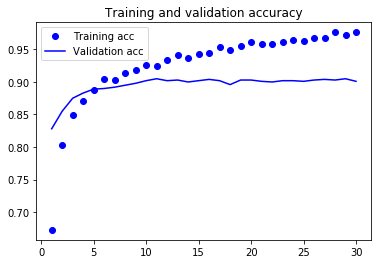

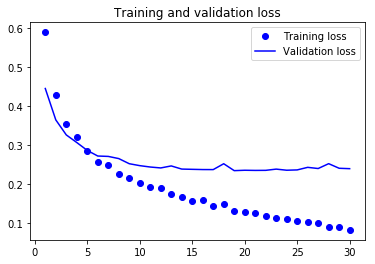

In [54]:
plot_history(history.history)

### using data augmention

In [10]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [11]:
conv_base.trainable = False

model.compile(optimizer=optimizers.rmsprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc'])

In [12]:
datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40, 
    shear_range=0.2,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    zoom_range=0.2, 
    fill_mode='nearest', 
    horizontal_flip=True)

train_generator = datagen.flow_from_directory(train_dir, target_size=(150,150), batch_size=batch_size, class_mode='binary')
val_generator = datagen.flow_from_directory(val_dir, target_size=(150,150), batch_size=batch_size, class_mode='binary')

history_freeze = model.fit_generator(
    train_generator, steps_per_epoch=100, epochs=100, validation_data=val_generator, validation_steps=50, verbose=0)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


max validation accuracy:  0.9649999916553498 epochs:  72
min validation loss:  0.11858211949234829 epochs:  44


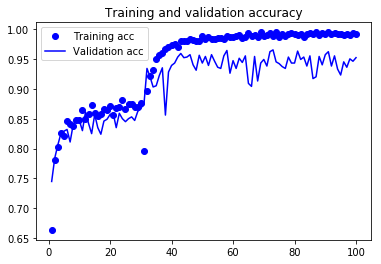

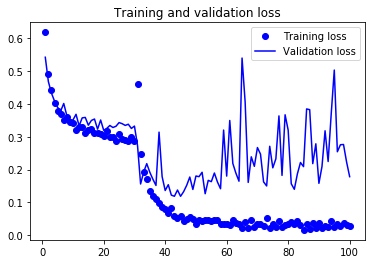

In [55]:
plot_history(history_freeze.history)

#### smoothing

In [ ]:
def smooth(points, factor=0.8):
    result = [points[0]]
    for p in points[1:]:
        prev = result[-1]
        result.append(prev*factor+(1-factor)*p)
    return result

max validation accuracy:  0.948869111461658 epochs:  82
min validation loss:  0.1494546333517114 epochs:  45


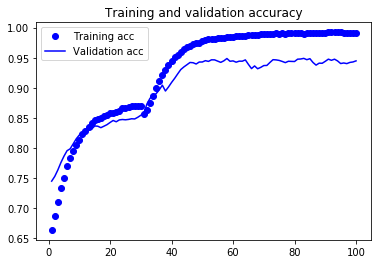

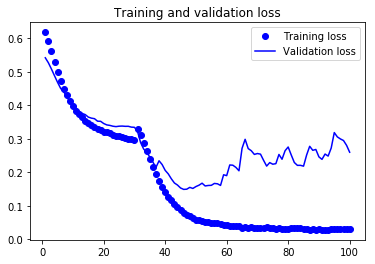

In [56]:
plot_history(history_freeze.history, smooth)

In [40]:
model.save('model_vgg16_freeze.h5')

# fine-tuning

In [43]:
conv_base.trainable = True

for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        layer.trainable = True
    elif layer.name == 'block5_conv2':
        layer.trainable = True
    elif layer.name == 'block5_conv3':
        layer.trainable = True
    else:
        layer.trainable = False
        
model.compile(optimizer=optimizers.rmsprop(lr=1e-5), loss='binary_crossentropy', metrics=['acc'])

In [44]:
history_freeze = model.fit_generator(
    train_generator, steps_per_epoch=100, epochs=100, validation_data=val_generator, validation_steps=50, verbose=0)

max validation accuracy:  0.9689999949932099 epochs:  51
min validation loss:  0.1682604450427516 epochs:  32


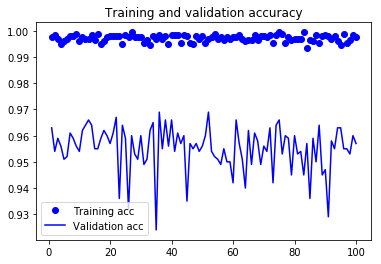

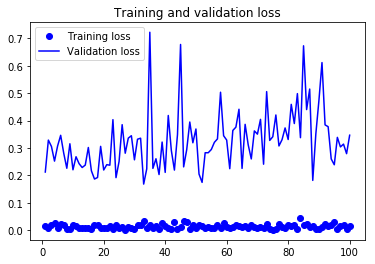

In [58]:
plot_history(history_tuned.history)

max validation accuracy:  0.9629999923706055 epochs:  0
min validation loss:  0.2122698426031525 epochs:  0


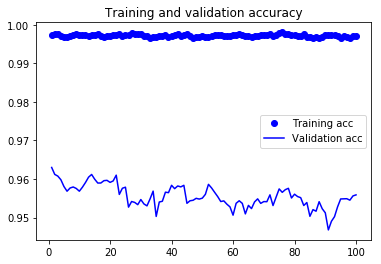

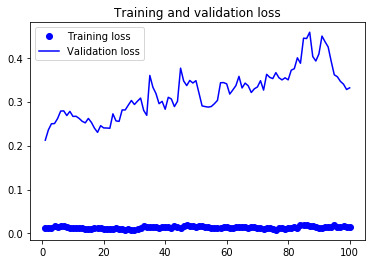

In [59]:
#smoothing

plot_history(history_tuned.history, smooth)